In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        625 non-null    object  
 1   GSS_CODE    625 non-null    object  
 2   HECTARES    625 non-null    float64 
 3   NONLD_AREA  625 non-null    float64 
 4   LB_GSS_CD   625 non-null    object  
 5   BOROUGH     625 non-null    object  
 6   POLY_ID     625 non-null    int64   
 7   geometry    625 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 39.2+ KB


In [3]:
df = pd.read_csv('https://data.london.gov.uk/download/ward-profiles-and-atlas/772d2d64-e8c6-46cb-86f9-e52b4c7851bc/ward-profiles-excel-version.csv',
                 encoding= 'unicode_escape', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Ward name                                                                    660 non-null    object 
 1   Old code                                                                     660 non-null    object 
 2   New code                                                                     660 non-null    object 
 3   Population - 2015                                                            660 non-null    float64
 4   Children aged 0-15 - 2015                                                    660 non-null    float64
 5   Working-age (16-64) - 2015                                                   660 non-null    float64
 6   Older people aged 65+ - 2015              

In [5]:
df = df[['New code','Population - 2015','In employment (16-64) - 2011','Number of jobs in area - 2013',
        'Number of properties sold - 2014','Average Public Transport Accessibility score - 2014',
        '% travel by bicycle to work - 2011']]
df.head()

,New code,Population - 2015,In employment (16-64) - 2011,Number of jobs in area - 2013,Number of properties sold - 2014,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011
0,E09000001,8100.0,4555.0,392400.0,309.0,7.9,5.3
1,E05000026,14750.0,5444.0,9500.0,151.0,6.0,0.8
2,E05000027,10600.0,4143.0,1000.0,119.0,3.1,1.0
3,E05000028,12700.0,4598.0,1300.0,191.0,2.9,1.6
4,E05000029,10400.0,3819.0,1900.0,108.0,2.3,1.2


In [6]:
df.columns = ['new_code','pop2015','in_employ','job_offer','properties_sold',
              'APTAscore','travel_by_bike']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   new_code         660 non-null    object 
 1   pop2015          660 non-null    float64
 2   in_employ        660 non-null    float64
 3   job_offer        658 non-null    float64
 4   properties_sold  660 non-null    float64
 5   APTAscore        659 non-null    float64
 6   travel_by_bike   660 non-null    float64
dtypes: float64(6), object(1)
memory usage: 36.2+ KB


In [7]:
pd.isnull(df).sum() > 0

new_code           False
pop2015            False
in_employ          False
job_offer           True
properties_sold    False
APTAscore           True
travel_by_bike     False
dtype: bool

In [8]:
print(df[df['job_offer'].isnull()])
print(df[df['APTAscore'].isnull()])

      new_code  pop2015  in_employ  job_offer  properties_sold  APTAscore  \
216  E05000241  11650.0     4166.0        NaN            114.0        2.9   
224  E05000249  12350.0     4949.0        NaN            133.0        3.9   

     travel_by_bike  
216            13.4  
224            14.6  
      new_code     pop2015   in_employ   job_offer  properties_sold  \
659  E92000001  54613400.0  24425633.0  27643600.0         871002.0   

     APTAscore  travel_by_bike  
659        NaN             2.9  


In [9]:
print(df.shape)

#df.drop(index=df[df.columns.values.isna()].index,axis = 0, inplace=True)
#df.drop(df.index[-1],inplace = True)

df = df.dropna()
print(df.shape)

(660, 7)
(657, 7)


In [10]:
df.sample()

,new_code,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
167,E05000192,13500.0,7364.0,7800.0,168.0,3.8,5.1


In [11]:
ppd = pd.merge(gdf, df, left_on='GSS_CODE', right_on='new_code', how='inner').reset_index()
ppd.shape
ppd.sample(3)

,index,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,new_code,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
518,518,Shadwell,E05000586,96.225,9.72,E09000030,Tower Hamlets,51234,"POLYGON ((535677.500 180538.500, 535449.800 18...",E05000586,15900.0,6534.0,3500.0,185.0,6.0,5.4
598,598,Green Street West,E05000486,80.281,0.00,E09000025,Newham,116826,"POLYGON ((540936.900 185070.100, 540956.400 18...",E05000486,15500.0,5873.0,4100.0,64.0,4.0,1.0
187,187,Underhill,E05000060,455.053,0.00,E09000003,Barnet,116789,"POLYGON ((519925.200 195151.100, 519919.900 19...",E05000060,17300.0,6874.0,4900.0,219.0,2.6,0.8


In [12]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [13]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

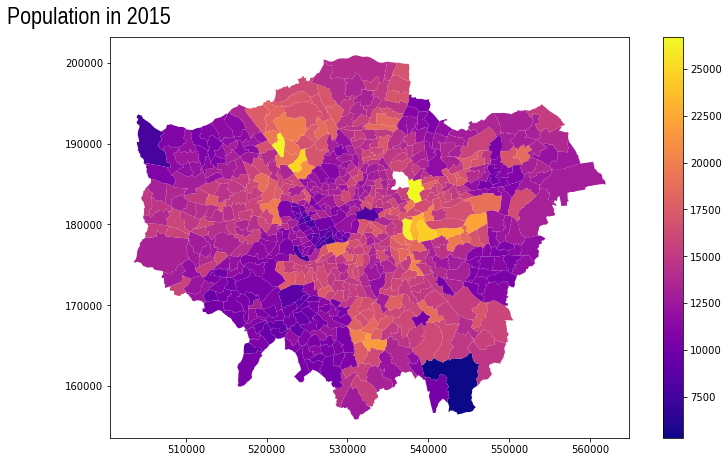

In [14]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='pop2015', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Population in 2015", x=0.025, size=24, **tfont);
#plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [15]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [16]:
ppd = ppd[['NAME','GSS_CODE','geometry','pop2015','in_employ','job_offer','properties_sold',
              'APTAscore','travel_by_bike']].copy()
ppd.head()

,NAME,GSS_CODE,geometry,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
0,Chessington South,E05000405,"POLYGON ((516401.600 160201.800, 516407.300 16...",10550.0,5291.0,5300.0,201.0,2.4,2.3
1,Tolworth and Hook Rise,E05000414,"POLYGON ((517829.600 165447.100, 517837.100 16...",10650.0,4993.0,5200.0,153.0,2.3,2.9
2,Berrylands,E05000401,"POLYGON ((518107.500 167303.400, 518114.300 16...",9800.0,4813.0,2000.0,172.0,2.8,4.6
3,Alexandra,E05000400,"POLYGON ((520480.000 166909.800, 520490.700 16...",9700.0,4464.0,2500.0,136.0,2.2,3.9
4,Beverley,E05000402,"POLYGON ((522071.000 168144.900, 522063.900 16...",10450.0,4807.0,4500.0,167.0,2.8,4.4


In [17]:
to_cluster = ppd[['GSS_CODE','pop2015','in_employ','job_offer','properties_sold',
              'APTAscore','travel_by_bike']].set_index('GSS_CODE').copy()
to_cluster.head()

,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
GSS_CODE,,,,,,
E05000405,10550.0,5291.0,5300.0,201.0,2.4,2.3
E05000414,10650.0,4993.0,5200.0,153.0,2.3,2.9
E05000401,9800.0,4813.0,2000.0,172.0,2.8,4.6
E05000400,9700.0,4464.0,2500.0,136.0,2.2,3.9
E05000402,10450.0,4807.0,4500.0,167.0,2.8,4.4


<AxesSubplot:ylabel='Frequency'>

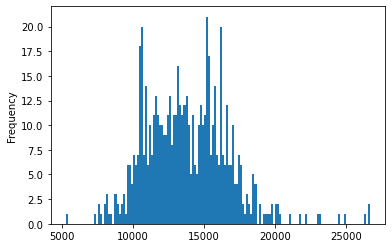

In [18]:
to_cluster.pop2015.plot.hist(bins=150)

In [19]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()

In [20]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
GSS_CODE,,,,,,
E05000081,-1.170056,-1.014083,-0.866672,0.113816,-0.872417,-0.973309
E05000192,-0.022724,0.877046,0.883466,-0.091446,0.259006,0.747573
E05000302,-0.577211,-0.695023,-1.251140,-1.322880,-0.431397,-1.270215
E05000558,-1.235126,-0.682781,-0.454723,0.087344,-0.146956,0.061376
E05000608,0.064731,0.119610,-0.513704,0.074010,0.024621,0.359603


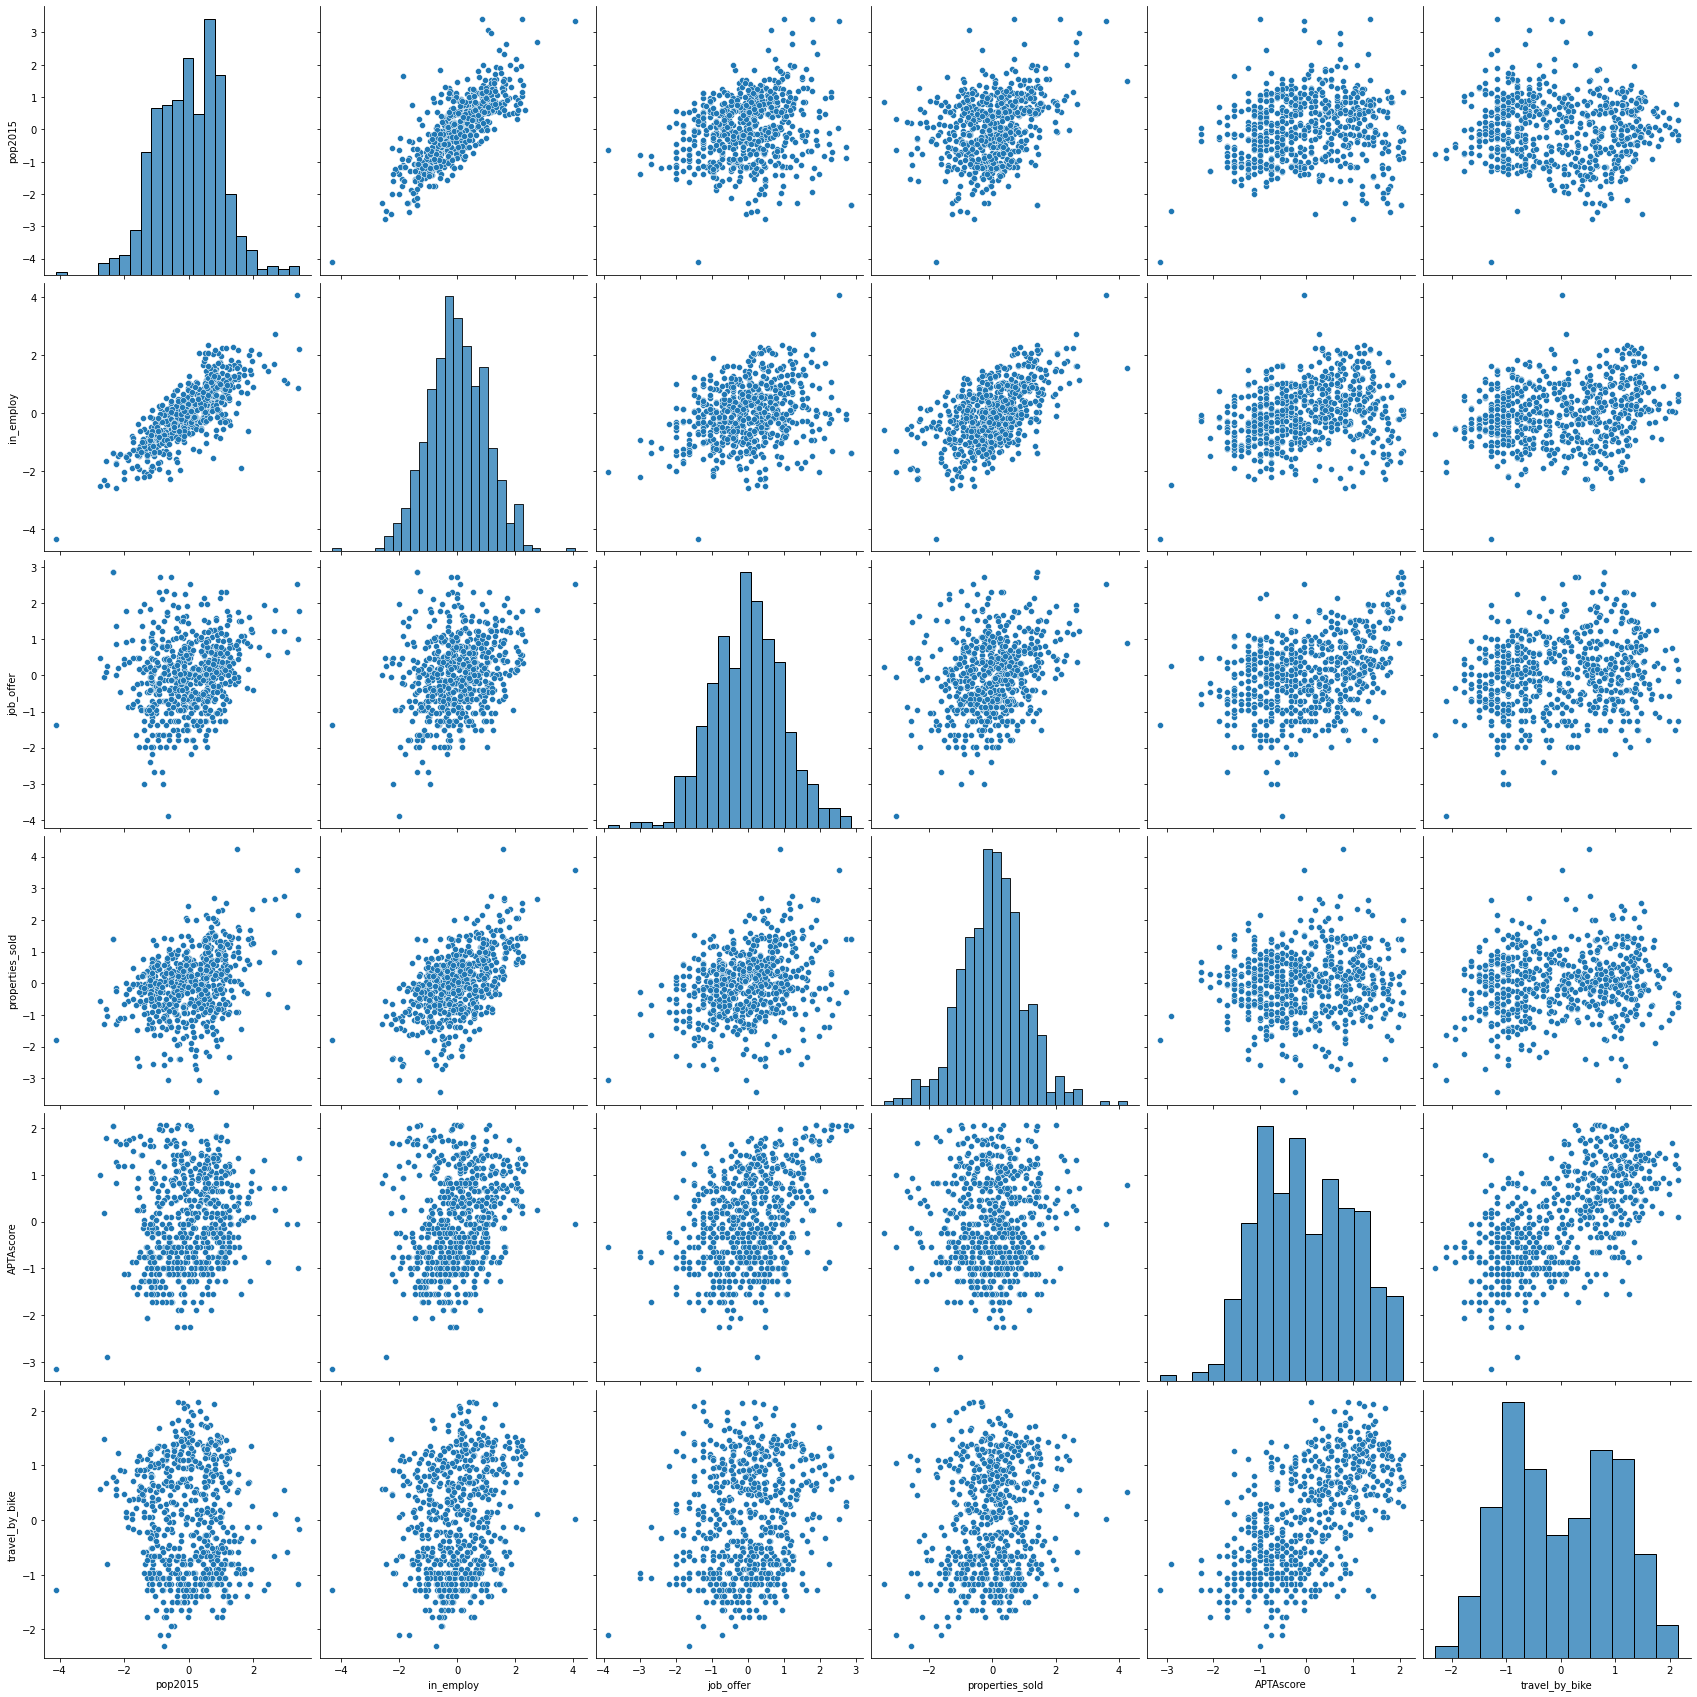

In [21]:
plot_norm = sns.pairplot(normed,height = 4)

In [22]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.4176468  0.25642912 0.13190747 0.12377561 0.04806851 0.02217249]


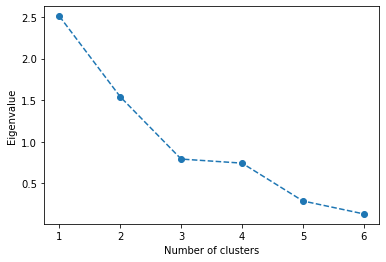

In [23]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [24]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.4176468  0.25642912]


In [25]:
list_var = normed.columns.tolist()
print(list_var)

['pop2015', 'in_employ', 'job_offer', 'properties_sold', 'APTAscore', 'travel_by_bike']


In [26]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike
0,-0.439394,-0.543396,-0.359322,-0.401940,-0.366926,-0.293855
1,0.431775,0.290819,-0.182888,0.227267,-0.548622,-0.585585


In [27]:
score_pca = pca.transform(normed)
score_pca

array([[ 1.06047176,  0.03103056],
       [ 1.42481921, -0.26366478],
       [ 1.65109026, -0.83960694],
       ...,
       [ 3.84324547,  0.06834343],
       [-0.79958095, -3.20046097],
       [-0.79958095, -3.20046097]])

In [28]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[2.50990305 1.54104434]


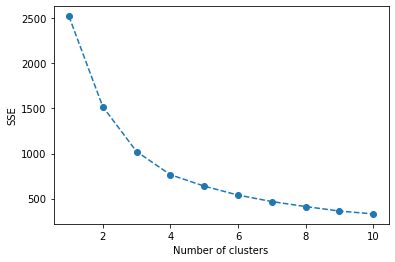

In [29]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [30]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

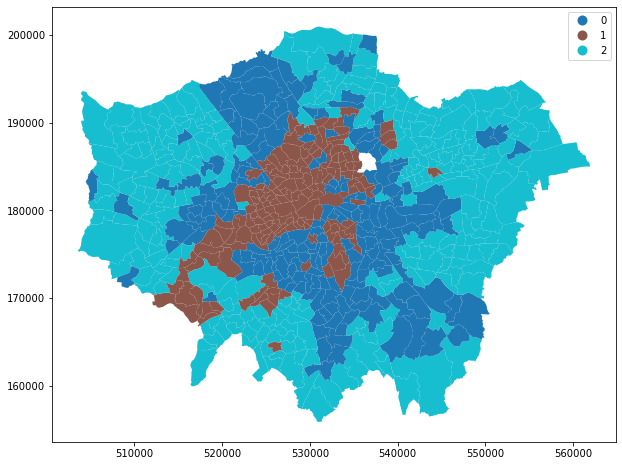

In [31]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [32]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [33]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [34]:
ppd_kpca.head()

,NAME,GSS_CODE,geometry,pop2015,in_employ,job_offer,properties_sold,APTAscore,travel_by_bike,Kmeans_Cluster,Component1,Component2,Segement
0,Chessington South,E05000405,"POLYGON ((516401.600 160201.800, 516407.300 16...",10550.0,5291.0,5300.0,201.0,2.4,2.3,2,1.060472,0.031031,Third
1,Tolworth and Hook Rise,E05000414,"POLYGON ((517829.600 165447.100, 517837.100 16...",10650.0,4993.0,5200.0,153.0,2.3,2.9,2,1.424819,-0.263665,Third
2,Berrylands,E05000401,"POLYGON ((518107.500 167303.400, 518114.300 16...",9800.0,4813.0,2000.0,172.0,2.8,4.6,2,1.651090,-0.839607,Third
3,Alexandra,E05000400,"POLYGON ((520480.000 166909.800, 520490.700 16...",9700.0,4464.0,2500.0,136.0,2.2,3.9,2,2.292526,-0.613746,Third
4,Beverley,E05000402,"POLYGON ((522071.000 168144.900, 522063.900 16...",10450.0,4807.0,4500.0,167.0,2.8,4.4,2,1.157541,-0.911063,Third


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


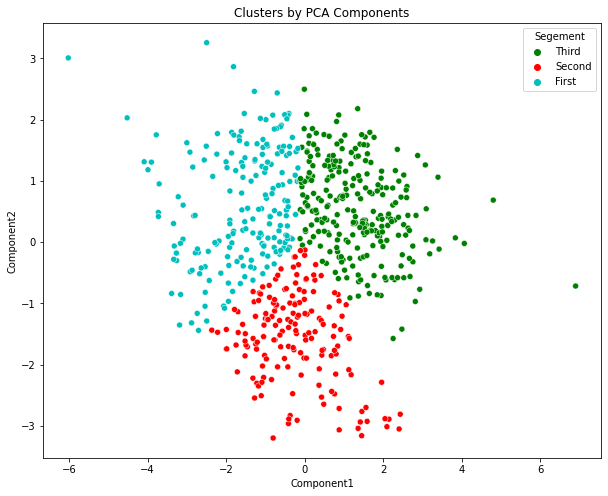

In [35]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()